### Setup

In [3]:
# Main
import numpy as np
import pandas as pd

# Modeling
import statsmodels.api as sm

# Unit root
from arch.unitroot import ADF, DFGLS, PhillipsPerron, KPSS, ZivotAndrews
from quantileADF import QAR, comparisonPlot

# Tests and function
from statsmodels.stats.stattools import jarque_bera

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Setup
repoUrl = 'https://raw.githubusercontent.com/vlad-yeghiazaryan/QADF/master/data/'
broadREERsUrl = repoUrl + 'broadREERs.csv'
narrowREERsUrl = repoUrl + 'narrowREERs.csv'
pd.io.formats.excel.ExcelFormatter.header_style = None

In [4]:
def univariate(data):
    univariateTests = pd.DataFrame()
    univariateTests['ADF'] = data.apply(lambda col: ADF(col).pvalue)
    univariateTests['DFGLS'] = data.apply(lambda col: DFGLS(col).pvalue)
    univariateTests['PP'] = data.apply(lambda col: PhillipsPerron(col).pvalue)
    univariateTests['KPSS'] = data.apply(lambda col: KPSS(col).pvalue)
    univariateTests['ZA'] = data.apply(lambda col: ZivotAndrews(col).pvalue)
    return univariateTests.applymap(lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)

In [5]:
def comparisonPlots(data,fileName='changesOverQuantiles'):
    figs = []
    for index, pos in enumerate(range(0, data.shape[1], 3)):
        columns = data.columns[pos: min(data.shape[1], pos+3)]
        figsize = (len(columns)*5, 6)
        countries = data[columns]
        fig = comparisonPlot(countries, figsize=figsize)
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{index+1}', dpi = 150)
    return figs

In [6]:
def markovRegimeSwitchingPlots(data, fileName='regimeSwitchingProbabilities'):
    figs = []
    for i, pos in enumerate(range(0, data.shape[1], 2)):
        columns = data.columns[pos: min(data.shape[1], pos+2)]
        figsize = (len(columns)*5, 6)
        fig = plt.figure()
        for index, country in enumerate(columns):
            mainModel = QAR(data[country])
            ax = fig.add_subplot(1, len(columns), index+1)
            mod = sm.tsa.MarkovRegression(mainModel.y, trend='c', k_regimes=2, order=2, freq='MS').fit()
            ylabel = 'Probability of being in the high regime'
            title = mainModel.name
            ax = mod.smoothed_marginal_probabilities[1].plot(title=title,ylabel=ylabel, figsize=(12,3))
            ax.axvline('2015-1-1', color='black')
            trans = ax.get_xaxis_transform()
            plt.text('2015-1-1', -.1, 'EAEU', transform=trans, weight='bold')
            ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{i+1}', dpi = 150)
    return figs

In [7]:
def saveToExcel(dataframe, path, def_properties={}):
    # Setup
    writer = pd.ExcelWriter(path)
    dataframe.style.set_properties(**def_properties).to_excel(writer)

    def dummyCriteria(f): return {'type': 'cell',
                                  'criteria': '!=', 'value': 0, 'format': f}

    def excel_colnum_string(n):
        string = ""
        while n > 0:
            n, remainder = divmod(n - 1, 26)
            string = chr(65 + remainder) + string
        return string

    # Accessing
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']
    colLetter = excel_colnum_string(dataframe.shape[1]+1)
    tableRange = 'A1:'+colLetter+str(dataframe.shape[0]+1)
    header = 'A1:'+colLetter+'1'
    footer = 'A'+str(dataframe.shape[0]+1) + \
        ':'+colLetter+str(dataframe.shape[0]+1)
    indexCol = 'A1:'+'A'+str(dataframe.shape[0]+1)

    # Styles
    defaultFormat = {'font_name': 'Calibri', 'font_size': 8,
                     'bg_color': '#FFFFFF',
                     'align': 'center',
                     'valign': 'vcenter',
                     'border': 0,
                     'shrink': True,
                     'text_wrap': True}
    columnFormat = workbook.add_format(defaultFormat)
    columnFormat.set_font_size(8)
    headerFormat = workbook.add_format(
        {**defaultFormat, **{'top': 5, 'bottom': 2, 'bold': True}})
    footerFormat = workbook.add_format({**defaultFormat, **{'bottom': 5}})
    indexFormat = workbook.add_format({**defaultFormat, **{'align': 'left'}})

    # Applying Styles
    worksheet.conditional_format(tableRange, dummyCriteria(columnFormat))
    worksheet.conditional_format(header, dummyCriteria(headerFormat))
    worksheet.conditional_format(footer, dummyCriteria(footerFormat))
    worksheet.conditional_format(indexCol, dummyCriteria(indexFormat))
    writer.save()
    print('Table saved to:', path)

In [8]:
broadREERs = pd.read_csv(broadREERsUrl, index_col=0, parse_dates=True)
narrowREERs = pd.read_csv(narrowREERsUrl, index_col=0, parse_dates=True)

# Extracting country information
countries = ['Armenia', 'Belarus', 'Kazakhstan', 'Kyrgyz Republic',
             'Moldova', 'Russian Federation', 'Tajikistan', 'Ukraine']

startDate = '2000-01-01'
startDateWithoutTaj = '1995-01-01'

data = broadREERs[countries].loc[startDate:]

# Changing data
dataLogs = data.apply(np.log, axis=1)
dataPtC = dataLogs.diff()[1:]

data.info()

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

### REERs of EAEU countries

In [16]:
data = pd.read_csv('./data/dataset.csv', index_col=0)

In [18]:
data['Belarus'][50:100]

Date
2004-03-01    105.951526
2004-04-01    107.693583
2004-05-01    108.860351
2004-06-01    109.315888
2004-07-01    109.309086
2004-08-01    110.299070
2004-09-01    109.670213
2004-10-01    108.359878
2004-11-01    105.924685
2004-12-01    103.864344
2005-01-01    103.295653
2005-02-01    104.468796
2005-03-01    104.501047
2005-04-01    105.710885
2005-05-01    107.123705
2005-06-01    109.700692
2005-07-01    111.158661
2005-08-01    110.242555
2005-09-01    109.926753
2005-10-01    111.318622
2005-11-01    112.061384
2005-12-01    112.025954
2006-01-01    109.532300
2006-02-01    109.475508
2006-03-01    108.761609
2006-04-01    108.085633
2006-05-01    105.940113
2006-06-01    106.992265
2006-07-01    106.873494
2006-08-01    105.837423
2006-09-01    106.545415
2006-10-01    107.243989
2006-11-01    106.580566
2006-12-01    104.381443
2007-01-01    105.775947
2007-02-01    105.717269
2007-03-01    105.133403
2007-04-01    103.197832
2007-05-01    103.103187
2007-06-01    103.64

In [2]:
ax = data.plot(kind='line', subplots=False, sharey=True, 
          layout=(1,1), figsize=(12, 5), title='REERs by country', legend=False)

ax.legend(bbox_to_anchor=(1, 1), loc='best')
mark = '2015'
ax.axvline(mark+'-1-1', color='black')
ax.text(mark+'-1-1', -0.06, 'EAEU', transform=ax.get_xaxis_transform(), weight='bold', fontsize='large')

plt.savefig('Outputs/REERsByCountry', dpi = 150, bbox_inches='tight')
plt.show()

NameError: name 'data' is not defined

In [9]:
colNames = {
    'count': 'N',
    'mean': 'Mean',
    'std': 'St.dev.',
    'min': 'Min.',
    'max': 'Max.',
    '50%': 'Median',
}
tests = ['Jarque-Bera', 'Jarque-Bera (P-value)', 'Skewness', 'Kurtosis']
include = ['N', 'Mean', 'Median', 'Min.', 'Max.', 'St.dev.',
           'Skewness', 'Kurtosis', 'Jarque-Bera', 'Jarque-Bera (P-value)']

# Summary Setup
summaryStatistics = data.describe().T
JB = data.apply(jarque_bera).T
summaryStatistics[tests] = JB
summaryStatistics.rename(columns=colNames, inplace=True)
summaryTable = summaryStatistics[include].applymap(
    lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)
summaryTable.index.name = 'Countries'
saveToExcel(summaryTable, path="Outputs/summaryStatistics.xlsx", def_properties={'text-align': 'center'})
summaryTable

Table saved to: Outputs/summaryStatistics.xlsx


,N,Mean,Median,Min.,Max.,St.dev.,Skewness,Kurtosis,Jarque-Bera,Jarque-Bera (P-value)
Countries,,,,,,,,,,
Armenia,251,86.436,91.964,60.748,112.670,12.978,-0.587,1.967,25.576,0.000
Belarus,251,92.156,93.926,63.490,121.250,15.739,-0.112,1.465,25.185,0.000
Kazakhstan,251,87.638,85.562,69.135,117.063,11.577,0.288,1.980,14.334,0.001
Kyrgyz Republic,251,95.324,98.990,76.395,113.535,9.665,-0.282,1.842,17.350,0.000
Moldova,251,101.414,105.679,65.751,139.276,19.526,-0.105,1.949,12.008,0.002
Russian Federation,251,87.958,89.740,47.244,112.963,15.747,-0.349,2.303,10.171,0.006
Tajikistan,251,99.532,100.077,75.248,124.610,11.582,-0.078,2.382,4.249,0.119
Ukraine,251,85.497,88.550,48.422,121.900,11.897,-0.365,2.993,5.561,0.062


In [10]:
univariateTable = univariate(dataLogs)
univariateTable.index.name = 'Countries'
saveToExcel(univariateTable, path='Outputs/univariateTests.xlsx')
univariateTable

Table saved to: Outputs/univariateTests.xlsx


,ADF,DFGLS,PP,KPSS,ZA
Countries,,,,,
Armenia,0.450,0.480,0.491,0.000,0.076
Belarus,0.812,0.857,0.656,0.000,0.153
Kazakhstan,0.329,0.098,0.609,0.035,0.000
Kyrgyz Republic,0.221,0.400,0.222,0.000,0.540
Moldova,0.541,0.856,0.582,0.000,0.745
Russian Federation,0.030,0.617,0.024,0.003,0.327
Tajikistan,0.578,0.427,0.795,0.000,0.169
Ukraine,0.301,0.117,0.182,0.002,0.168


/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


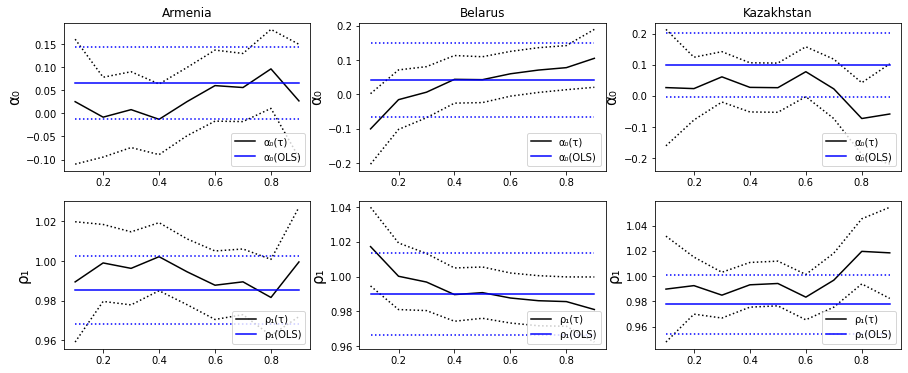

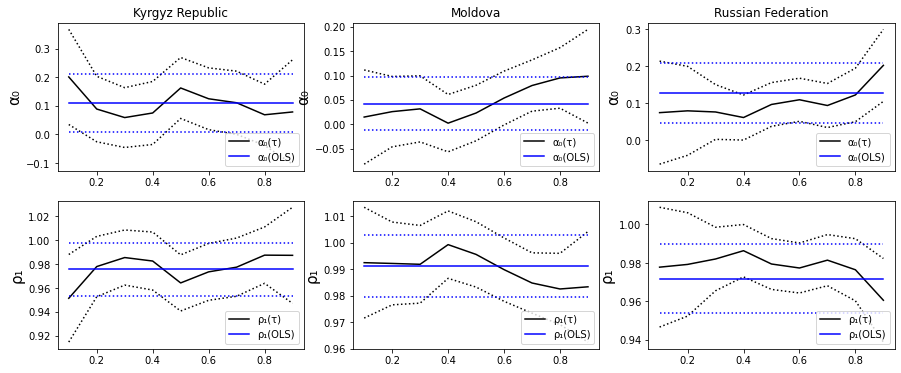

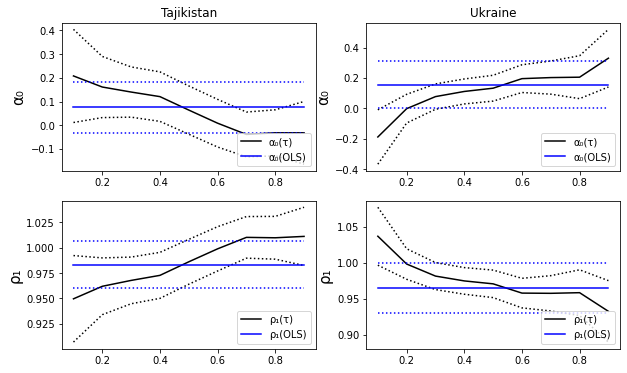

In [11]:
comparisonPlots(dataLogs)
plt.show()

/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


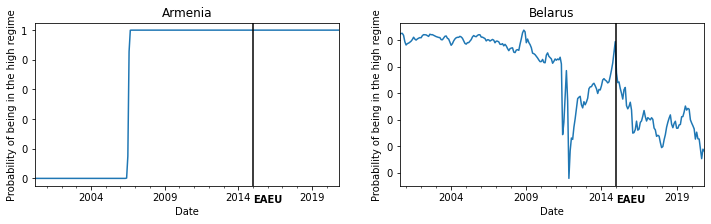

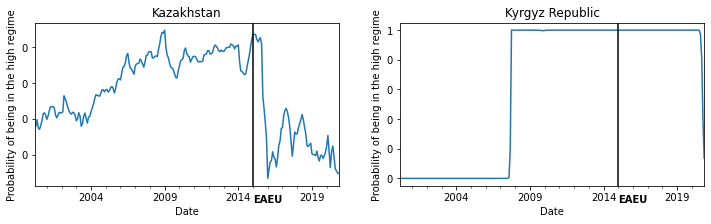

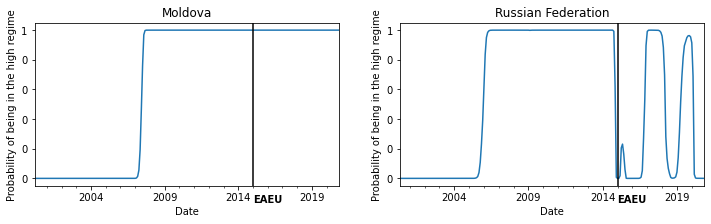

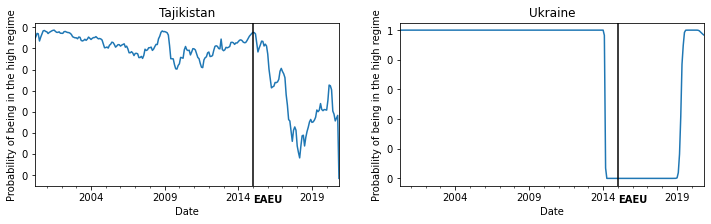

In [11]:
markovRegimeSwitchingPlots(data)
plt.show()

In [19]:
def getCorrespQuant(col, value=100):
    if type(value) != int:
        value = value[col.name]
    return (abs(col-value).idxmin())

data100 = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[100]).T
data100.name = 'REER=100'

dataEAEU = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[data.mean()]).T
dataEAEU.name = 'REER=Mean (entire period)'

dataBefore = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[data.loc[:'2015-1-1'].mean()]).T
dataBefore.name = 'REER=Mean (before EAEU)'

dataAfter = data.quantile(np.arange(0.1, 1, 0.01)).apply(getCorrespQuant, args=[data.loc['2015-1-1':].mean()]).T
dataAfter.name = 'REER=Mean (after EAEU)'

targets = {
    'Armenia': 'N/A',
    'Belarus': 'N/A',
    'Kazakhstan': 'N/A',
    'Kyrgyz Republic': '0.1,0.5',
    'Moldova': '0.7,0.8',
    'Russian Federation': '0.5-0.9*',
    'Tajikistan': '0.1-0.4',
    'Ukraine': '0.4-0.9*'
}

before_targets = {
    'Armenia': 'N/A',
    'Belarus': '0.5-0.9*',
    'Kazakhstan': '0.2',
    'Kyrgyz Republic': '0.1',
    'Moldova': '0.6, 0.8',
    'Russian Federation': 'N/A',
    'Tajikistan': '0.1-0.4*',
    'Ukraine': '0.4-0.7*'
}

after_targets = {
    'Armenia': 'N/A',
    'Belarus': 'N/A',
    'Kazakhstan': '0.1-0.4*',
    'Kyrgyz Republic': '0.7,0.8*',
    'Moldova': '0.9',
    'Russian Federation': '0.5-0.9*',
    'Tajikistan': '0.2-0.7',
    'Ukraine': 'N/A'
}

dataTargets = pd.Series(targets.values(), index=targets.keys(), name='Mean Reversion (entire period)')
EAEU_beforeTargets = pd.Series(before_targets.values(), index=before_targets.keys(), name='Mean Reversion (before EAEU)')
EAEU_afterTargets = pd.Series(after_targets.values(), index=after_targets.keys(), name='Mean Reversion (after EAEU)')

# Constructing the table
meanBehavior = pd.concat([data100, dataEAEU, dataBefore, dataAfter, 
                          EAEU_beforeTargets, EAEU_afterTargets, dataTargets], axis=1)
meanBehavior.index.name = 'Countries'
saveToExcel(meanBehavior, path='Outputs/meanBehavior.xlsx')
meanBehavior

Table saved to: Outputs/meanBehavior.xlsx


,REER=100,REER=Mean (entire period),REER=Mean (before EAEU),REER=Mean (after EAEU),Mean Reversion (before EAEU),Mean Reversion (after EAEU),Mean Reversion (entire period)
Countries,,,,,,,
Armenia,0.95,0.34,0.32,0.73,N/A,N/A,N/A
Belarus,0.57,0.46,0.57,0.19,0.5-0.9*,N/A,N/A
Kazakhstan,0.83,0.53,0.58,0.25,0.2,0.1-0.4*,N/A
Kyrgyz Republic,0.56,0.42,0.39,0.66,0.1,"0.7,0.8*","0.1,0.5"
Moldova,0.39,0.41,0.36,0.82,"0.6, 0.8",0.9,"0.7,0.8"
Russian Federation,0.73,0.47,0.48,0.41,N/A,0.5-0.9*,0.5-0.9*
Tajikistan,0.49,0.47,0.68,0.18,0.1-0.4*,0.2-0.7,0.1-0.4
Ukraine,0.95,0.41,0.62,0.20,0.4-0.7*,N/A,0.4-0.9*


### Capturing Convergence

In [135]:
EAEU = pd.Series((data.index > '2015-01-01').astype(int), index=data.index, name='EAEU')
mainModel = QAR(data['Armenia'], EAEU)

In [136]:
res = mainModel.fit(0.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                Armenia   Pseudo R-squared:               0.8725
Model:                       QuantReg   Bandwidth:                       1.085
Method:                 Least Squares   Sparsity:                        3.635
Date:                Fri, 21 May 2021   No. Observations:                  249
Time:                        00:20:59   Df Residuals:                      245
                                        Df Model:                            3
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5308      0.842      0.631      0.529      -1.127       2.188
Armenia.L.1      0.9950      0.010     99.108      0.000       0.975       1.015
ΔArmenia.L.1     0.0769      0.057      1.356      0.176      -0.035       0.189
EAEU            -0.0898      0.289     -0.311      0.756      -0.659       0.479
================================================================================
"""

In [139]:
switchingRes = sm.tsa.MarkovRegression(mainModel.y, exog=mainModel.X, k_regimes=2, 
                                       trend='nt', freq='MS', switching_exog=[True, True, False, True],
                                       dates=data.index).fit()

In [140]:
switchingRes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Armenia   No. Observations:                  249
Model:               MarkovRegression   Log Likelihood                -526.882
Date:                Fri, 21 May 2021   AIC                           1073.763
Time:                        00:21:24   BIC                           1108.938
Sample:                    01-01-2000   HQIC                          1087.922
                         - 11-01-2020                                         
Covariance Type:               approx                                         
                              Regime 0 parameters                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          92.2714   4.46e-13   2.07e+14      0.000      92.271      92.271
Armenia.L.1    -0.4633   2.35e-11  -1.97e+10      0.000      -0.463      -0.463
EAEU         1.002e-34  1.87e-107   5.37e+72      0.000       1e-34       1e-34
                              Regime 1 parameters                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5966      0.930      1.717      0.086      -0.226       3.419
Armenia.L.1     0.9823      0.011     88.575      0.000       0.961       1.004
EAEU            0.0063      0.319      0.020      0.984      -0.619       0.632
                            Non-switching parameters                            
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ΔArmenia.L.1     0.1568      0.063      2.502      0.012       0.034       0.280
sigma2           4.0314      0.361     11.158      0.000       3.323       4.739
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     7.441e-21    403.203   1.85e-23      1.000    -790.264     790.264
p[1->0]     1.017e-21   3.06e-07   3.32e-15      1.000   -5.99e-07    5.99e-07
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.96e+39. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

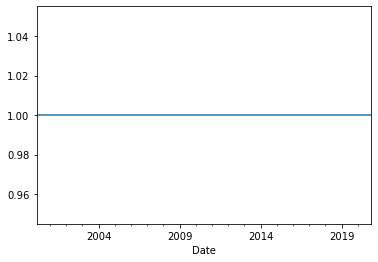

In [141]:
switchingRes.smoothed_marginal_probabilities[1].plot()

In [8]:
# MarkovAutoregression, MarkovRegression, markov_switching
# ETSModel
# ExponentialSmoothing
# SimpleExpSmoothing
# STL
# SVAR
# VAR
# VECM
# mod = SETAR(dta, order=2, delay=2, ar_order=11, thresholds=(7.43,))
# res = mod.fit()
# SETAR(endog=data['Armenia'], order=2, ar_order=1)